In [1]:
#Door_Dash_Revised
#This version will implement proper feature selection methods
#Train random forest, xgboost , linear regression, and neural networks to the doordash dataset

In [2]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from scipy.stats import sem
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
import datetime as dt

In [3]:
#Create a pandas dataframe 
dash_data = pd.read_csv("/Users/user/Downloads/historical_data.csv")

dash_data = pd.DataFrame(dash_data)

dash_data.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
#convert times to datetime format so we can preform operation
dash_data['created_at'] = pd.to_datetime(dash_data['created_at'], format="%Y-%m-%d %H:%M:%S")
dash_data['actual_delivery_time'] = pd.to_datetime(dash_data['actual_delivery_time'], format="%Y-%m-%d %H:%M:%S")

#Insert a new column that represents the total time it takes to arrive
#We do this by subtracting the starting time and the actual delivery time
y =(dash_data['actual_delivery_time']-dash_data['created_at']).dt.total_seconds()
dash_data.insert(3 , "time_to_arrive" ,y)
dash_data.head(5)



,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,4024.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,1781.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,3075.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,2390.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [5]:
#The 'created_at' feature might be of importance but should only extract the time

#Take the just the time in hours, mintues and second
y = dash_data["created_at"].dt.strftime('%H:%M:%S')
dash_data.insert(3 , "created_at_hour", y)


In [6]:
#Take the Year, month and day from the "created_at" feature
x = dash_data["created_at"].dt.strftime("%Y-%m-%d")
dash_data.insert(4,"created_at_day" , x )


In [7]:
#View results
dash_data.head(5)

,market_id,created_at,actual_delivery_time,created_at_hour,created_at_day,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,22:24:17,2015-02-06,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,21:49:25,2015-02-10,4024.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,20:39:28,2015-01-22,1781.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,21:21:45,2015-02-03,3075.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,02:40:36,2015-02-15,2390.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [8]:
#Create a new feature that represents the number of availible doordashers (total_onshift_dashers/(total_busy_dashers))
ratio_free_dashers = dash_data["total_busy_dashers"]/dash_data["total_onshift_dashers"]
ratio_free_dashers
dash_data.insert(14 , "total_free_dashers" ,ratio_free_dashers)


In [9]:
null_count = dash_data.isna().sum()
print(null_count)

market_id                                         987
created_at                                          0
actual_delivery_time                                7
created_at_hour                                     0
created_at_day                                      0
time_to_arrive                                      7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_free_dashers                              19838
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_durati

In [10]:
#Drop all NaN values from feature with less then 1000
dash_data.dropna(subset=["estimated_store_to_consumer_driving_duration","market_id","order_protocol",'time_to_arrive'], inplace=True)


In [11]:
null_count = dash_data.isna().sum()
null_count

market_id                                           0
created_at                                          0
actual_delivery_time                                0
created_at_hour                                     0
created_at_day                                      0
time_to_arrive                                      0
store_id                                            0
store_primary_category                           3995
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_free_dashers                              19654
total_onshift_dashers                           16107
total_busy_dashers                              16107
total_outstanding_orders                        16107
estimated_order_place_durati

In [12]:
#There are some concerning missing NaN values in the "total_onshift_dashers" , "total_busy_dashers", "total_outstanding_orders"
#Check the distribution of these variables

#Create a version of the data set without the dropped values
dash_data_free = dash_data.dropna()



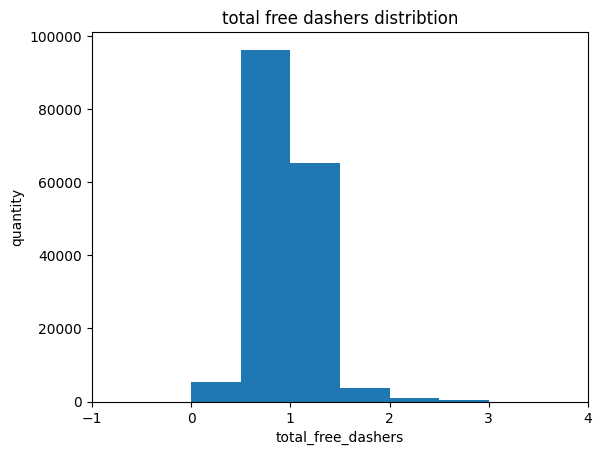

In [13]:
#Plot values of interest
plt.hist(dash_data_free["total_free_dashers"],bins=[0,0.5,1,1.5,2,2.5,3])
plt.title("total free dashers distribtion")
plt.xlabel("total_free_dashers")
plt.ylabel('quantity')
plt.xlim(-1,4)
plt.show()

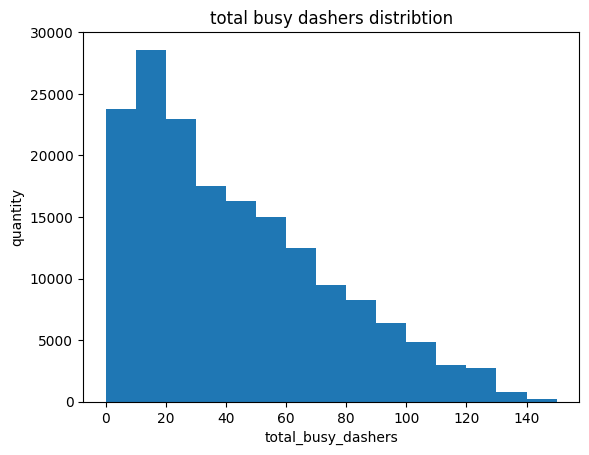

In [14]:
plt.hist(dash_data_free["total_busy_dashers"],bins=range(0,160,10))
plt.title("total busy dashers distribtion")
plt.xlabel("total_busy_dashers")
plt.ylabel('quantity')
plt.show()


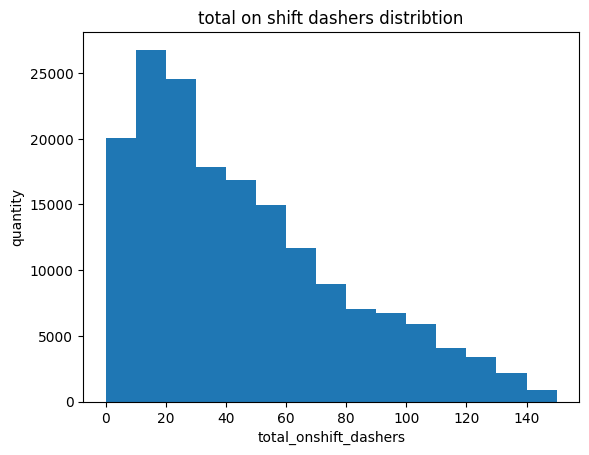

In [15]:
plt.hist(dash_data_free["total_onshift_dashers"],bins=range(0,160,10))
plt.title("total on shift dashers distribtion")
plt.xlabel("total_onshift_dashers")
plt.ylabel('quantity')
plt.show()


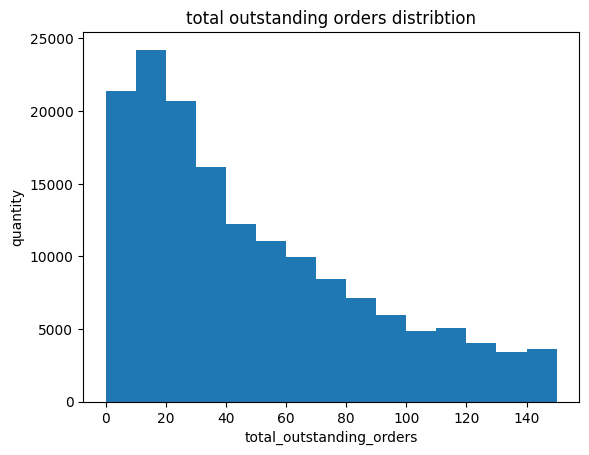

In [16]:
plt.hist(dash_data_free['total_outstanding_orders'],bins=range(0,160,10))
plt.title("total outstanding orders distribtion")
plt.xlabel('total_outstanding_orders')
plt.ylabel('quantity')
plt.show()


In [17]:
#Observe, right skewed data.  Impute using Median and adjust the "free_dashers" column acc0rdingly
dash_data["total_busy_dashers"] = dash_data["total_busy_dashers"].fillna(dash_data["total_busy_dashers"].median())
dash_data["total_onshift_dashers"] = dash_data["total_onshift_dashers"].fillna(dash_data["total_onshift_dashers"].median())
dash_data['total_outstanding_orders'] = dash_data["total_outstanding_orders"].fillna(dash_data["total_outstanding_orders"].median())
dash_data["total_free_dashers"] = dash_data["total_busy_dashers"]/dash_data["total_onshift_dashers"]
dash_data["total_busy_dashers"].isnull().sum()

0

In [18]:
#Drop all values in which total_onshift_dashers is 0 since that would result in a NaN value for total_free_dashers
dash_data.loc[dash_data["total_onshift_dashers"] == 0] = None

dash_data.dropna(subset="total_free_dashers" , inplace = True)

In [19]:
dash_data.isnull().sum()

market_id                                          0
created_at                                         0
actual_delivery_time                               0
created_at_hour                                    0
created_at_day                                     0
time_to_arrive                                     0
store_id                                           0
store_primary_category                          3950
order_protocol                                     0
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_free_dashers                                 0
total_onshift_dashers                              0
total_busy_dashers                                 0
total_outstanding_orders                           0
estimated_order_place_duration                

In [20]:
#For now, drop the null values for the store primary category so we cna visualize
dash_data.dropna(inplace=True)

In [21]:
#Before moving on to deal with the Null values in "store_primary_category" apply some tests to visualize how the data if the data is at all seperated into classes
#Create data set with just numerical value
dash_data_numeric = dash_data[["max_item_price","min_item_price","num_distinct_items","time_to_arrive",	"subtotal",  "total_items"	,"total_free_dashers",	"total_outstanding_orders","total_onshift_dashers"  ,"total_busy_dashers",	"estimated_order_place_duration",	"estimated_store_to_consumer_driving_duration"]]

In [22]:
#Check how many categories there are for each category variable

#For store primary category
print(dash_data["store_primary_category"].value_counts().count())
#At most we should have 74

#For Market IDs
print(dash_data["market_id"].value_counts().count())

#For order_protocol
print(dash_data["order_protocol"].value_counts().count())


74
6
7


In [23]:
#K-means Clustering Elobow plot
#Scale data first
scaler = StandardScaler()
dash_data_numeric_scaled = scaler.fit_transform(dash_data_numeric)



In [24]:
#Create an elbow plot to get a rough idea on how the data is split categorically (if at all) set the limit to 74 since thats the max amount of categorical variables 
#elbow=[]
#for i in range(1,74):
    #kmeansmodel = KMeans(n_clusters = i , random_state=10)
    #kmeansmodel.fit(dash_data_numeric_scaled)
    #elbow.append(kmeansmodel.inertia_)

#Plot
#plt.plot(elbow)
#plt.xlabel("Clusters")
#plt.ylabel("Inertia")
#plt.show()

In [25]:
print(dash_data_numeric.shape)
print(dash_data.shape)


(187866, 12)
(187866, 20)


In [26]:
#Use PCA to visualize data
#Create a new data frame with the order protocol variable

#Give dash_data and dash_data numeric a ID name so they can be merged
dash_data["ID"] = dash_data.index + 1
dash_data_numeric["ID"] = dash_data_numeric.index + 1
dash_data_for_pca = dash_data_numeric.merge(dash_data[['ID',"order_protocol"]], left_on="ID",right_on = "ID")
dash_data_for_pca

C:\Users\user\AppData\Local\Temp\ipykernel_23384\2495646655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dash_data_numeric["ID"] = dash_data_numeric.index + 1


,max_item_price,min_item_price,num_distinct_items,time_to_arrive,subtotal,total_items,total_free_dashers,total_outstanding_orders,total_onshift_dashers,total_busy_dashers,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,ID,order_protocol
0,1239.0,557.0,4.0,3779.0,3441.0,4.0,0.424242,21.0,33.0,14.0,446.0,861.0,1,1.0
1,1400.0,1400.0,1.0,4024.0,1900.0,1.0,2.000000,2.0,1.0,2.0,446.0,690.0,2,2.0
2,1604.0,820.0,3.0,1586.0,4771.0,4.0,0.750000,18.0,8.0,6.0,446.0,289.0,9,3.0
3,1525.0,1525.0,1.0,2273.0,1525.0,1.0,1.200000,8.0,5.0,6.0,446.0,795.0,15,1.0
4,2195.0,1425.0,2.0,2988.0,3620.0,2.0,1.000000,7.0,5.0,5.0,446.0,205.0,16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187861,649.0,345.0,3.0,3907.0,1389.0,3.0,1.000000,23.0,17.0,17.0,251.0,331.0,197424,4.0
187862,825.0,405.0,4.0,3383.0,3010.0,6.0,0.916667,14.0,12.0,11.0,251.0,915.0,197425,4.0
187863,399.0,300.0,3.0,3008.0,1836.0,5.0,1.051282,40.0,39.0,41.0,251.0,795.0,197426,4.0
187864,535.0,535.0,1.0,3907.0,1175.0,1.0,1.000000,12.0,7.0,7.0,446.0,384.0,197427,1.0


In [27]:
dash_data_for_pca.drop(columns="ID")

,max_item_price,min_item_price,num_distinct_items,time_to_arrive,subtotal,total_items,total_free_dashers,total_outstanding_orders,total_onshift_dashers,total_busy_dashers,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,order_protocol
0,1239.0,557.0,4.0,3779.0,3441.0,4.0,0.424242,21.0,33.0,14.0,446.0,861.0,1.0
1,1400.0,1400.0,1.0,4024.0,1900.0,1.0,2.000000,2.0,1.0,2.0,446.0,690.0,2.0
2,1604.0,820.0,3.0,1586.0,4771.0,4.0,0.750000,18.0,8.0,6.0,446.0,289.0,3.0
3,1525.0,1525.0,1.0,2273.0,1525.0,1.0,1.200000,8.0,5.0,6.0,446.0,795.0,1.0
4,2195.0,1425.0,2.0,2988.0,3620.0,2.0,1.000000,7.0,5.0,5.0,446.0,205.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187861,649.0,345.0,3.0,3907.0,1389.0,3.0,1.000000,23.0,17.0,17.0,251.0,331.0,4.0
187862,825.0,405.0,4.0,3383.0,3010.0,6.0,0.916667,14.0,12.0,11.0,251.0,915.0,4.0
187863,399.0,300.0,3.0,3008.0,1836.0,5.0,1.051282,40.0,39.0,41.0,251.0,795.0,4.0
187864,535.0,535.0,1.0,3907.0,1175.0,1.0,1.000000,12.0,7.0,7.0,446.0,384.0,1.0


In [28]:
#Generate PCA
pca_numerical,pca_protocol =dash_data_for_pca,dash_data_for_pca["order_protocol"] 
pca = PCA()
pca_dash =pca.fit_transform(pca_numerical)


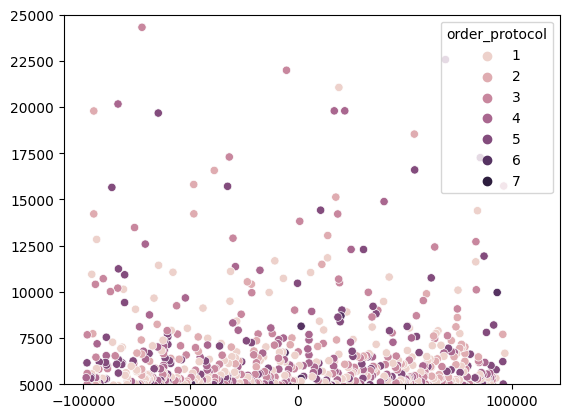

In [29]:
sns.scatterplot(x = pca_dash[:,0] , y = pca_dash[:,1], hue=pca_protocol)
plt.ylim([5000,25000])
plt.show()



In [30]:
#Based on the visulization and the elbow plot, it is safe to remove the categorical variables as well as the created_at and actual_delivery_time
dash_data_new = dash_data.drop(columns=["order_protocol","market_id","actual_delivery_time","store_id","store_primary_category","order_protocol","ID"])
dash_data_new.head(10)

,created_at,created_at_hour,created_at_day,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_free_dashers,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,2015-02-06 22:24:17,22:24:17,2015-02-06,3779.0,4.0,3441.0,4.0,557.0,1239.0,0.424242,33.0,14.0,21.0,446.0,861.0
1,2015-02-10 21:49:25,21:49:25,2015-02-10,4024.0,1.0,1900.0,1.0,1400.0,1400.0,2.000000,1.0,2.0,2.0,446.0,690.0
8,2015-02-16 00:11:35,00:11:35,2015-02-16,1586.0,4.0,4771.0,3.0,820.0,1604.0,0.750000,8.0,6.0,18.0,446.0,289.0
14,2015-02-12 03:36:46,03:36:46,2015-02-12,2273.0,1.0,1525.0,1.0,1525.0,1525.0,1.200000,5.0,6.0,8.0,446.0,795.0
15,2015-01-27 02:12:36,02:12:36,2015-01-27,2988.0,2.0,3620.0,2.0,1425.0,2195.0,1.000000,5.0,5.0,7.0,446.0,205.0
16,2015-02-06 00:42:42,00:42:42,2015-02-06,5267.0,3.0,4475.0,3.0,925.0,1825.0,0.250000,4.0,1.0,1.0,446.0,542.0
17,2015-02-08 02:04:17,02:04:17,2015-02-08,4976.0,3.0,4375.0,3.0,1325.0,1625.0,0.666667,6.0,4.0,3.0,446.0,789.0
18,2015-01-31 04:35:54,04:35:54,2015-01-31,4296.0,2.0,3150.0,2.0,1425.0,1725.0,2.250000,4.0,9.0,12.0,446.0,548.0
19,2015-01-31 02:21:23,02:21:23,2015-01-31,3019.0,2.0,950.0,2.0,150.0,700.0,1.000000,24.0,24.0,26.0,446.0,212.0
20,2015-01-31 23:45:12,23:45:12,2015-01-31,1733.0,5.0,1285.0,3.0,150.0,400.0,1.083333,12.0,13.0,11.0,446.0,424.0


In [31]:
dash_data_new.drop(columns="created_at", inplace=True)

In [32]:
dash_data_new

,created_at_hour,created_at_day,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_free_dashers,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,22:24:17,2015-02-06,3779.0,4.0,3441.0,4.0,557.0,1239.0,0.424242,33.0,14.0,21.0,446.0,861.0
1,21:49:25,2015-02-10,4024.0,1.0,1900.0,1.0,1400.0,1400.0,2.000000,1.0,2.0,2.0,446.0,690.0
8,00:11:35,2015-02-16,1586.0,4.0,4771.0,3.0,820.0,1604.0,0.750000,8.0,6.0,18.0,446.0,289.0
14,03:36:46,2015-02-12,2273.0,1.0,1525.0,1.0,1525.0,1525.0,1.200000,5.0,6.0,8.0,446.0,795.0
15,02:12:36,2015-01-27,2988.0,2.0,3620.0,2.0,1425.0,2195.0,1.000000,5.0,5.0,7.0,446.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,00:19:41,2015-02-17,3907.0,3.0,1389.0,3.0,345.0,649.0,1.000000,17.0,17.0,23.0,251.0,331.0
197424,00:01:59,2015-02-13,3383.0,6.0,3010.0,4.0,405.0,825.0,0.916667,12.0,11.0,14.0,251.0,915.0
197425,04:46:08,2015-01-24,3008.0,5.0,1836.0,3.0,300.0,399.0,1.051282,39.0,41.0,40.0,251.0,795.0
197426,18:18:15,2015-02-01,3907.0,1.0,1175.0,1.0,535.0,535.0,1.000000,7.0,7.0,12.0,446.0,384.0


In [33]:
#Test for multicollinearity, first split date time into hour and minute
dash_data_new["hour"] = dash_data["created_at"].dt.strftime('%H')
dash_data_new["minute"] = dash_data["created_at"].dt.strftime('%M')

dash_data_new.head(1)

,created_at_hour,created_at_day,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_free_dashers,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour,minute
0,22:24:17,2015-02-06,3779.0,4.0,3441.0,4.0,557.0,1239.0,0.424242,33.0,14.0,21.0,446.0,861.0,22,24


In [34]:
#Get rid of date time variables, this includes the created_at_day and variables like it
dash_data_train = dash_data_new.drop(columns=['created_at_hour','created_at_day'])

In [35]:
#Create a copy of data
dash_data_org = dash_data_train

#Change date time variables to numerics
dash_data_train = dash_data_train.astype('float64', copy=True)

In [36]:
dash_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187866 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   time_to_arrive                                187866 non-null  float64
 1   total_items                                   187866 non-null  float64
 2   subtotal                                      187866 non-null  float64
 3   num_distinct_items                            187866 non-null  float64
 4   min_item_price                                187866 non-null  float64
 5   max_item_price                                187866 non-null  float64
 6   total_free_dashers                            187866 non-null  float64
 7   total_onshift_dashers                         187866 non-null  float64
 8   total_busy_dashers                            187866 non-null  float64
 9   total_outstanding_orders                      18

In [37]:
#Create Pairs Plot
#sns.pairplot(dash_data_train)

In [38]:
#Test for multicollinearity
#Create function that tests for collinearity between variables
#First we want to remove the redundancies in our correlation matrix
def remove_redundant(df):
    labels_drop = set()
    col = df.columns
#Want to iterate through the columns
    for i in range(df.shape[1]):
        for j in range(0,i+1):
        #Add to the drop list all the values on the diagnal and above.  Since we will have redundant terms
            labels_drop.add((col[i] , col[j]))
    return labels_drop

def create_corr_ranking(df , n=10):
    #Get the absolute value of the correlation matrix and format it as a vertical list
    abs_corr = df.corr().abs().unstack()
    #Call the function we used recently to remove duplicated
    drop = remove_redundant(df)
    #Drop all the redundant (and identity) pairs and make sure to from highest to smallest
    abs_corr = abs_corr.drop(labels = drop).sort_values(ascending = False)
    return abs_corr[0:n]


In [39]:
rank_dash = create_corr_ranking(dash_data_train , n=20)
rank_dash

total_onshift_dashers     total_busy_dashers                0.942036
                          total_outstanding_orders          0.934746
total_busy_dashers        total_outstanding_orders          0.931509
total_items               num_distinct_items                0.760825
subtotal                  num_distinct_items                0.682125
total_items               subtotal                          0.555243
min_item_price            max_item_price                    0.542474
subtotal                  max_item_price                    0.506313
num_distinct_items        min_item_price                    0.450190
total_items               min_item_price                    0.393214
total_onshift_dashers     hour                              0.368243
total_outstanding_orders  hour                              0.353221
total_busy_dashers        hour                              0.344007
max_item_price            hour                              0.186932
subtotal                  hour    

In [40]:
#Create some new features, first of all total_onshift and total busy can be quantified using total_free
#Drop otal_onshift and total_busy
dash_data_train.drop(columns=["total_onshift_dashers","total_busy_dashers"],inplace=True)
dash_data_train.head(1)

,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour,minute
0,3779.0,4.0,3441.0,4.0,557.0,1239.0,0.424242,21.0,446.0,861.0,22.0,24.0


In [41]:
rank_dash_1 = create_corr_ranking(dash_data_train , n=20)
rank_dash_1

total_items               num_distinct_items                0.760825
subtotal                  num_distinct_items                0.682125
total_items               subtotal                          0.555243
min_item_price            max_item_price                    0.542474
subtotal                  max_item_price                    0.506313
num_distinct_items        min_item_price                    0.450190
total_items               min_item_price                    0.393214
total_outstanding_orders  hour                              0.353221
max_item_price            hour                              0.186932
subtotal                  hour                              0.184285
total_outstanding_orders  estimated_order_place_duration    0.164354
subtotal                  total_outstanding_orders          0.128908
max_item_price            total_outstanding_orders          0.126079
num_distinct_items        hour                              0.113978
max_item_price            estimate

In [42]:
#Create a new feature called 'ratio_distinct'
dash_data_train["ratio_distinct"] = dash_data_train["num_distinct_items"]/dash_data_train["total_items"]

In [43]:
#Drop total_items and num_distince
dash_data_train.drop(columns=["total_items","num_distinct_items"],inplace=True)

In [44]:
rank_dash_2 = create_corr_ranking(dash_data_train,n=10)
rank_dash_2

min_item_price            max_item_price                    0.542474
subtotal                  max_item_price                    0.506313
total_outstanding_orders  hour                              0.353221
subtotal                  ratio_distinct                    0.200403
max_item_price            hour                              0.186932
subtotal                  hour                              0.184285
max_item_price            ratio_distinct                    0.180250
min_item_price            ratio_distinct                    0.175844
total_outstanding_orders  estimated_order_place_duration    0.164354
subtotal                  total_outstanding_orders          0.128908
dtype: float64

In [45]:
#Create a new feature called take the range of the price of an item
dash_data_train["range_price"] = dash_data_train["max_item_price"] - dash_data_train["min_item_price"]

#Drop the max and min price
dash_data_train.drop(columns=["max_item_price","min_item_price"],inplace=True)

In [46]:
dash_data_train.head(10)

,time_to_arrive,subtotal,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour,minute,ratio_distinct,range_price
0,3779.0,3441.0,0.424242,21.0,446.0,861.0,22.0,24.0,1.00,682.0
1,4024.0,1900.0,2.000000,2.0,446.0,690.0,21.0,49.0,1.00,0.0
8,1586.0,4771.0,0.750000,18.0,446.0,289.0,0.0,11.0,0.75,784.0
14,2273.0,1525.0,1.200000,8.0,446.0,795.0,3.0,36.0,1.00,0.0
15,2988.0,3620.0,1.000000,7.0,446.0,205.0,2.0,12.0,1.00,770.0
16,5267.0,4475.0,0.250000,1.0,446.0,542.0,0.0,42.0,1.00,900.0
17,4976.0,4375.0,0.666667,3.0,446.0,789.0,2.0,4.0,1.00,300.0
18,4296.0,3150.0,2.250000,12.0,446.0,548.0,4.0,35.0,1.00,300.0
19,3019.0,950.0,1.000000,26.0,446.0,212.0,2.0,21.0,1.00,550.0
20,1733.0,1285.0,1.083333,11.0,446.0,424.0,23.0,45.0,0.60,250.0


In [47]:
rank_dash_4 = create_corr_ranking(dash_data_train , n=10)
rank_dash_4

subtotal                        range_price                                     0.510971
total_outstanding_orders        hour                                            0.353221
subtotal                        ratio_distinct                                  0.200403
                                hour                                            0.184285
total_outstanding_orders        estimated_order_place_duration                  0.164354
hour                            range_price                                     0.151131
subtotal                        total_outstanding_orders                        0.128908
total_outstanding_orders        range_price                                     0.097966
estimated_order_place_duration  range_price                                     0.039035
total_outstanding_orders        estimated_store_to_consumer_driving_duration    0.038945
dtype: float64

In [48]:
#The correlations look good, create a pairs plot of the dat
#sns.pairplot(dash_data_train)
#plt.show()

In [49]:
#Notice one outlier, remove
dash_data_train.loc[dash_data_train["time_to_arrive"] > 300000] = None
dash_data_train.dropna(inplace=True)

In [50]:
#sns.pairplot(dash_data_train)
#plt.show()

In [54]:
#Specify target variable
y = dash_data_train["time_to_arrive"]

#Specify predictors
x = dash_data_train.drop(columns="time_to_arrive")

In [55]:
#Split into test and training
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.2, random_state=100)

In [56]:
#Create function that fits a regression model and calculates RMSE
def regression(model,xtest,xtrain,ytrain,ytest):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    error = mean_squared_error(ytest , ypred,squared=True)
    rooterror = mean_squared_error(ytest , ypred,squared=False)
    
    r2 = r2_score(ytest , ypred)
    
    final_model = model
    return final_model,error,r2,rooterror

In [57]:
#Fit a linear regression
linear = regression(LinearRegression(),x_test , x_train , y_train , y_test)

#Check the RMSE
linear[3]

1059.835834589673

In [ ]:
#Create a validated Linear Regression model
validated_linear = cross_validate(LinearRegression(), x_train, y_train , cv=5)

In [58]:
#Fit a Random Forest
forest = regression(RandomForestRegressor(),x_test , x_train , y_train , y_test)

#Check the RMSE
forest[3]

1044.598280555319

In [62]:
#Cross Validate
#validated_forest = cross_validate(RandomForestRegressor(),x_train , y_train ,cv=5,scoring='neg_root_mean_squared_error')

{'fit_time': array([82.57189822, 87.59750342, 86.54957509, 71.15684056, 84.23514748]),
 'score_time': array([1.11457491, 1.18474293, 0.98077679, 0.85360742, 0.95065808]),
 'test_score': array([-1034.71447729, -1058.28434161, -1061.17492519, -1106.49492884,
        -1033.29396334])}

In [64]:
np.mean([-1034.71447729, -1058.28434161, -1061.17492519, -1106.49492884,-1033.29396334])

-1058.792527254

In [59]:
#Fit an XGBoost
train_reg = xgb.DMatrix(x_train , y_train)
test_reg = xgb.DMatrix(x_test, y_test)



In [60]:
#Before moving to cross validation lets tune our hyperparametres
#Use grid search to tune parametres, come up with some reasonable parametres
#params_tune = {'max_depth':[3,5,6,7,8],'learning_rate':[0.3,0.01,0.1,0.2],'n_estimators':[15,16,17,18],'subsample':[0.6,0.7,0.8]}

#specify the XGB regressor

#xgbr = xgb.XGBRegressor(seed=100)

#Run Grid search
#search = GridSearchCV(estimator=xgbr , param_grid=params_tune , scoring='neg_mean_squared_error',verbose=1)

#search.fit(x_train,y_train)

#search.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 18, 'subsample': 0.8}

In [67]:
#Input Tuned Parametres into a cross validated Boosted Tree
tuned_params = {"objective":"reg:squarederror","tree_method":"gpu_hist",'learning_rate': 0.3, 'max_depth': 6, 'subsample': 0.8}

validated_model = xgb.cv(params=tuned_params , dtrain = train_reg , num_boost_round=40 ,nfold=50)

validated_model.min()